In [ ]:
! pip install --pre pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 14.5

In [ ]:
! pip install category_encoders

# 영업 성공 여부 분류 경진대회

# 1. 데이터 확인

### 필수 라이브러리

In [ ]:
import pandas as pd
import numpy as np
import re
from pycaret.classification import *
import category_encoders as ce
from time import time

### 데이터 셋 읽어오기

In [ ]:
pd.set_option('display.max_rows', None) # DataFrame의 모든 행 출력
pd.set_option('display.max_columns', None) # DataFrame의 모든 열 출력

In [ ]:
# df_train = pd.read_csv("train.csv") # 학습용 데이터
# df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv("/content/drive/My Drive/lg_aimers/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/lg_aimers/original_submission.csv")
city_list = pd.read_csv('/content/drive/My Drive/lg_aimers/oecd_city.csv').iloc[1:,0:1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 전처리까지만 사용

df_all = pd.concat([df_train, df_test])

# 2. 전처리

## 고정현 전처리 (customer_country)

In [ ]:
df_all['customer_country'] = df_all['customer_country'].str.lower()
df_all['customer_country'] = df_all['customer_country'].str.replace(' ', '')
df_all['customer_country'] = df_all['customer_country'].str.replace('//', '/')
df_all['customer_country'] = df_all['customer_country'].str.replace('//', '/')
df_all['customer_country'] = df_all['customer_country'].str.replace(r'/$', '', regex=True)
df_all['customer_country'] = df_all['customer_country'].str.replace(r'^/', '', regex=True)

In [ ]:


city_list = city_list.rename(columns = {'#NAME?' : 'name'})
city_list.loc[:,'name'] = city_list['name'].apply( lambda x : x.replace(' ', ''))
city_list['name'] = city_list['name'].str.lower()
country_cities = {}
current_country = None

for ind, row in city_list.iterrows():

    if not re.search(r'\d', row['name']):
        current_country = row['name'].split(':')[1]
        country_cities[current_country] = []

    else:
        if current_country:
            city_name = row['name'].split(':')[1]
            city_name_cleaned = re.sub(r'\s*\([^)]*\)', '', city_name).strip()
            country_cities[current_country].append(city_name_cleaned)

countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia",
    "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin",
    "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi",
    "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia",
    "Comoros", "Congo", "Costa Rica", "Cote d'Ivoire", "Croatia",
    "Cuba", "Cyprus", "Czech Republic", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
    "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji", "Finland", "France",
    "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau",
    "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
    "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "southkorea", "Kosovo",
    "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
    "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania",
    "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique",
    "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia",
    "Norway", "Oman", "Pakistan", "Palau", "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines",
    "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines",
    "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
    "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka",
    "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
    "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine",
    "u.a.e", "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City",
    "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe",\
    'us', 'puertorico', 'türkiye', 'usa',\
    'hongkong'
]


countries = list(map(lambda x : x.replace(' ', ''), countries))
countries = [country.lower() for country in countries]

pattern_updated = '|'.join([f'\\b{country}\\b|{country}$' for country in countries])
pattern2 = r'[A-Za-z]{2}\d{5}$'
pattern3 = r'salem|ny|nevada|ohio|kansascity|chulavista|wichita|oh44483|keshena|andersenafb|goleta|cincinnati'
pattern4 = r'madurai|mumbai|ludhiana|bangalore'
pattern5 = r'medellin'
pattern6 = r'macedonia'
pattern7 = r'charlestown'
pattern8 = r'上海'

def classify_country(x):
    if re.search(pattern3, x, re.IGNORECASE):
        return 'unitedstates'
    elif re.search(pattern4, x, re.IGNORECASE):
        return 'india'
    elif re.search(pattern5, x, re.IGNORECASE):
        return 'colombia'
    elif re.search(pattern6, x, re.IGNORECASE):
        return 'northmacedonia'
    elif re.search(pattern7, x, re.IGNORECASE):
        return 'saintkittsandnevis'
    elif re.search(pattern8, x, re.IGNORECASE):
        return 'china'
    else:
        return x



country_patterns = {country: '|'.join(map(re.escape, cities)) for country, cities in country_cities.items()}

def classify_country2(sentence):
    for country, pattern in country_patterns.items():
        if re.search(pattern, sentence, re.IGNORECASE):
            return country
    return sentence

final_map = {'us' : 'unitedstates', 'usa' : 'unitedstates', 'korea' : 'southkorea', 'tã¼rkiye': 'türkiye', 'czechia' : 'czechrepublic',
            'slovakia' :'slovakrepublic'}

In [ ]:
df_all['customer_country'] = df_all['customer_country'].fillna('undefined')
df_all.loc[:,'customer_country'] = df_all['customer_country'].apply\
    (lambda x : re.search(pattern_updated, x, re.IGNORECASE).group() if re.search(pattern_updated, x, re.IGNORECASE) else x)

df_all.loc[:,'customer_country'] = df_all['customer_country'].apply\
    (lambda x: 'unitedstates' if re.search(pattern2, x) else x)
df_all['customer_country'] = df_all['customer_country'].apply(classify_country)
df_all['customer_country'] = df_all['customer_country'].apply(classify_country2)
df_all['customer_country'] = df_all['customer_country'].apply(lambda x : final_map[x] if x in final_map.keys() else x)
df_all['customer_country'] = df_all['customer_country'].apply(lambda x: x if x in countries else 'undefined')

In [ ]:
country_ratio = pd.crosstab(df_all['customer_country'], df_all['is_converted'])
country_ratio['sum'] = country_ratio[False]+country_ratio[True]
country_ratio['ratio'] = country_ratio[True]/country_ratio['sum']
country_ratio = country_ratio.sort_values('ratio', ascending=False)
country_ratio.head(30)

is_converted,False,True,sum,ratio
customer_country,,,,
gambia,0,2,2,1.000000
laos,1,2,3,0.666667
coted'ivoire,3,4,7,0.571429
congo,4,5,9,0.555556
taiwan,24,26,50,0.520000
burkinafaso,3,3,6,0.500000
seychelles,1,1,2,0.500000
gabon,2,2,4,0.500000
liberia,1,1,2,0.500000


## 권순찬 전처리 (inquiry_type, customer_position, expected_timeline)

In [ ]:
df_all['inquiry_type'] = df_all['inquiry_type'].str.lower()
category_counts = df_all['inquiry_type'].value_counts()
categories_to_remove = category_counts[category_counts <= 12].index
df_all.loc[df_all['inquiry_type'].isin(categories_to_remove), 'inquiry_type'] = 'other'

similar_categories = ['others', 'other_', 'etc.']
df_all['inquiry_type'].replace(similar_categories, 'other', inplace=True)

similar_categories_mapping = {
    'quotation_or_purchase_consultation': 'quotation or purchase consultation',
    'technical consultation': 'technical support',
    'technical': 'technical support',
    'sales': 'sales inquiry'
}

df_all['inquiry_type'] = df_all['inquiry_type'].replace(similar_categories_mapping)
df_all['inquiry_type'].unique()

array(['quotation or purchase consultation', 'product information',
       'other', 'usage or technical consultation', 'trainings',
       'services', 'sales inquiry', 'technical support',
       'request for partnership', nan, 'request a demo',
       'request for distributorship', 'request for quotation or purchase',
       'request for technical consulting', 'customer suggestions'],
      dtype=object)

In [ ]:

position_mapping = {
    'ceo/founder': 'CEO/Founder', 'founder': 'CEO/Founder', 'chief executive officer': 'CEO/Founder',
    'ceo/fundador': 'CEO/Founder', 'the big boss': 'CEO/Founder',
    'vice president': 'Vice President', 'vicepresident': 'Vice President', 'vp': 'Vice President',
    'c-level executive': 'C-Level Executive', 'c-levelexecutive': 'C-Level Executive',
    'leadership/executive office/owner': 'C-Level Executive',
    'director': 'Director', 'business unit director': 'Director',
    'associate/analyst': 'Associate/Analyst', 'associate professor': 'Associate/Analyst',
    'assistant professor': 'Associate/Analyst', 'asst prof.': 'Associate/Analyst',
    'entry level': 'Entry Level', 'entrylevel': 'Entry Level',
    'manager': 'Manager', 'gerente': 'Manager',
    'consultant': 'Consultant', 'commercial consultant': 'Consultant',
    'architecture/consult': 'Consultant', 'architect/consultant': 'Consultant',

    'teacher': 'Education Professional', 'educator': 'Education Professional',
    'professor': 'Education Professional', 'physics teacher': 'Education Professional',
    'maths lecturer': 'Education Professional', 'quantitative aptitude faculty': 'Education Professional',
    'english trainer for ielts,toefl,pte,gre,sat exams.': 'Education Professional', 'pgt physics': 'Education Professional',
    'chemistry teacher': 'Education Professional', 'math and physics teacher': 'Education Professional',
    'assistant professor of enlish': 'Education Professional', 'professor of mathematics': 'Education Professional',
    'physics and mathematics teacher': 'Education Professional',
    # 기타 분류
    'other': 'Other', 'others': 'Other', 'not applicable': 'Other', 'no influence': 'Other',
    'other - please specify - cedia association': 'Other',
    'this is a consume display requirement for home purpose.': 'Not Specified',
    'bulgaria': 'Not Specified', 'exhibitiontv': 'Not Specified'
}


df_all['customer_position'] = df_all['customer_position'].replace(position_mapping)

In [ ]:

df_all['customer_position'] = df_all['customer_position'].str.lower()

category_counts = df_all['customer_position'].value_counts()
categories_to_remove = category_counts[category_counts <= 30].index
df_all.loc[df_all['customer_position'].isin(categories_to_remove), 'customer_position'] = 'other'
df_all['customer_position'].unique()

array(['entry level', 'ceo/founder', 'partner', 'manager',
       'vice president', 'associate/analyst', 'c-level executive', 'none',
       'director', 'other', 'intern', 'trainee', 'installer', 'hospital',
       'end-user'], dtype=object)

In [ ]:
timeline_mapping = {
    # 시간 프레임 관련 값
    'less than 3 months': 'less than 3 months',
    '3 months ~ 6 months': '3 to 6 months',
    '6 months ~ 9 months': '6 to 9 months',
    '9 months ~ 1 year': '9 months to 1 year',
    'more than a year': 'more than a year',
    'less than 6 months': 'less than 6 months',
    '3_months_~_6_months': '3 to 6 months',
    'less_than_3_months': 'less than 3 months',
    '6_months_~_9_months': '6 to 9 months',
    '9_months_~_1_year': '9 months to 1 year',
    'more_than_a_year': 'more than a year',

    # 상황 설명 값
    'quote has been sent to customer.': 'quote sent',
    'client not interested in product..': 'client not interested',
    'being followed up': 'being followed up',
    'update- 7th aug--demo given. customer will confirm next week': 'demo given - follow up',
    'details send': 'details sent',
    'requires detail for tender. no purchase requirement right now.': 'details required for tender',
    'the client is not having any requirement hence closig in system.': 'client has no requirement',
    'discussed with client details mailed.': 'details mailed to client',
    'he is looking for video wall & idb for his office.': 'looking for specific products',
    'details shared': 'details shared',
    'demo to be aligned': 'demo to be scheduled',
    'update- 13th spet--follow up to be done on 15th sept': 'follow up scheduled',
    'partner is already in touch with our rd, orno.': 'partner in touch with representative',
    'rnr': 'no response received',
    'scheduling a meeting': 'meeting scheduled',
    'customer want demo of idb.': 'customer wants demo',
    'already shared quotation through si.': 'quotation shared',
    'quotation shared.': 'quotation shared',
    'duplicate lead': 'duplicate lead',
    'invalid lead': 'invalid lead',
    'demo scheduled for first week feb': 'demo scheduled',
    'forwarded to bdo, being followed up': 'being followed up by business development officer',
    'spoke with custome he want 43" tv': 'customer wants specific product',
    'don’t have budget': 'no budget',
    'client shall get back for exploring demo of idb': 'client will get back regarding demo',
    'already in discussion with partner from bangalore': 'in discussion with partner',
    'require demo price send': 'demo and price inquiry',
    'size not available': 'specific size not available',
    'eol model new model quote requirment after 30 days.': 'end of life model, new model required after 30 days',
    'need to discuss with client in next two months.': 'discussion planned with client',
    'spoken to client, he will check if they need demo and confirm': 'client will confirm about demo',
    '29thsep2021:-no such requirement as of now': 'no requirement as of now',
    'purchase planning after 3 months': 'planning to purchase after 3 months',
    '09-02-2022 requested for boq of requirement': 'bill of quantities requested',
    'converted this lead into opportunity.': 'lead converted into opportunity',
    'demo scheduled for 24th oct': 'demo scheduled',
    'discussed with client. we need to align demo.': 'discussion with client about demo',
    'require demo': 'demo required',
    'client is looking for 86" display with vc solution': 'client looking for specific display with solution',
    'quote sent to customer.': 'quote sent to customer',
    'under discussion': 'under discussion',
    'meeting planned for further discussion': 'meeting planned',
    'customer will come for demo in next week': 'customer will come for demo',
    'he want demo next week': 'demo requested next week',
    'call and discused to custome customer wants demo.': 'customer wants demo, discussed over call',
    'demo planned, will update further status once its completed': 'demo planned and update pending',
    'quote sent, the client is required demo in june': 'quote and demo scheduled in june',
    'will come for the demo': 'client will come for demo',
    'customer has not answering call': 'customer not answering'
}


df_all['expected_timeline'] = df_all['expected_timeline'].replace(position_mapping)

In [ ]:

df_all['expected_timeline'].fillna('undefined', inplace=True)
df_all['expected_timeline'] = df_all['expected_timeline'].str.lower().str.replace('_', '')
df_all['expected_timeline'] = df_all['expected_timeline'].str.lower().str.replace('.', '')
df_all['expected_timeline'] = df_all['expected_timeline'].str.lower().str.replace(' ', '')
category_counts = df_all['expected_timeline'].value_counts()
categories_to_remove = category_counts[category_counts <= 22].index
df_all.loc[df_all['expected_timeline'].isin(categories_to_remove), 'expected_timeline'] = 'etc'

df_all['expected_timeline'].unique()

array(['lessthan3months', 'undefined', '3months~6months', '9months~1year',
       'morethanayear', '6months~9months', 'etc', 'beingfollowedup',
       'lessthan6months'], dtype=object)

## 박소해 전처리 (customer_job, business_subarea)

In [ ]:
# null to 0
df_all.update(df_all[['historical_existing_cnt','id_strategic_ver','it_strategic_ver', 'idit_strategic_ver',
                          'com_reg_ver_win_rate', 'ver_win_rate_x', 'ver_win_ratio_per_bu']].fillna(0))

# preprocess object-type columns
str_cols = df_all.columns[df_all.dtypes==object]
df_all[str_cols] = df_all[str_cols].fillna('undefined')  # null to 'undefined'
df_all[str_cols] = df_all[str_cols].apply(lambda x: x.str.replace(' ', ''))  # remove spaces
df_all[str_cols] = df_all[str_cols].apply(lambda x: x.str.lower())  # lower case

df_all[str_cols] = df_all[str_cols].apply(lambda x: x.str.replace(pat=r'[^a-z0-9]', repl=r'', regex=True))  # remove special characters (case 1. all, including non-eng to eng)
# df_all[str_cols] = df_all[str_cols].apply(lambda x: x.str.replace(pat=r'[^a-z0-9,/]', repl=r'', regex=True))  # remove special characters (case 2. only a few for tokenizing issue)

# merging
df_all = df_all.replace(dict.fromkeys(['etc', 'others'], 'other'))

In [ ]:
#1.
df_all['customer_job'] = df_all['customer_job'].replace('accountexec/manager', 'accountmanagement')

#2.
df_all['customer_job'] = df_all['customer_job'].replace('accountspayable', 'accounting')

#3.
specific_values = ['admin', 'administración', 'administration', 'administrative', 'adminisztráció', 'amministrativo',
                   'imagingadministrator', 'itadmin', 'itadministrator', 'networkadministrator', 'pacsadministrator',
                   'platformadministrator', 'systemsadministrator']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'admin' if x in specific_values else x)

#4.
df_all['customer_job'] = df_all['customer_job'].replace('administrativeassistant', 'adminassistant')

#5.
df_all['customer_job'] = df_all['customer_job'].replace('advertisingandpromotionsteam', 'advertising')
df_all['customer_job'] = df_all['customer_job'].replace('storepromotions', 'advertising')
df_all['customer_job'] = df_all['customer_job'].replace('tradeshowevent', 'advertising')

#6.
specific_values2 = ['architect', 'architect/owner', 'architectassinteriores', 'arquitecto/consultor', 'projectarchitect']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'architect' if x in specific_values2 else x)

#7.
specific_values3 = ['artanddesign','arte_e_design', 'arteydiseño','artist,leadonequipmentselection', 'arts_and_design', 'artsanddesign']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'artist' if x in specific_values3 else x)

#8.
specific_values4 = ['assistinservingfood', 'serving', 'servingfood', 'servingrobot', 'waiter']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'serving' if x in specific_values4 else x)

#9.
specific_values5 = ['a/vprojectmanager', 'avestimator', 'avprojectmanager', 'avtech', 'avtechnician']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'avtechnician' if x in specific_values5 else x)

#10.
specific_values6 = ['authorize(youareresponsibleformakingthefinaldecision)', 'purchasingauthority']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'authorizer' if x in specific_values6 else x)

#11.
df_all['customer_job'] = df_all['customer_job'].replace('publicbidder', 'bidder')

#12.
specific_values7 = ['business_development', 'businessdevelopment']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'businessdevelopment' if x in specific_values7 else x)

#13.
specific_values8 = ['cctvmonetoring', 'cctvview']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'cctvoperator' if x in specific_values8 else x)

#14.
specific_values9 = ['ceo', 'ceo/founder', 'chief', 'clevelexecutive', 'coo', 'decider', 'decisionmaker',
                    'finalapproval', 'head', 'president', 'presidentforsennco', 'thebigboss', 'underboss',
                    'vicepresident', 'vp/gm']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'chief' if x in specific_values9 else x)

#15.
specific_values10 = ['chiefeng', 'chiefengineer', 'chiefofengineering']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'chiefengineer' if x in specific_values10 else x)

#16.
specific_values11 = ['chirurgien', 'cirugano', 'doctor', 'főorvos',  'profesionaldecirugía', 'surgeryprofessional',
                     'surgeryprofessional\u200b']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'doctor' if x in specific_values11 else x)

#17.
specific_values12 = ['contractor', 'cintractor', 'managingcontractor']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'contractor' if x in specific_values12 else x)

#18.
specific_values13 = ['consultant', 'consultant,cabinetfabricator', 'consultant/purchaser', 'consultent', 'consulting']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'consultant' if x in specific_values13 else x)

#19.
specific_values14 = ['coordinator', 'corporate/office', 'correspondence', 'costaravteam']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'corporate' if x in specific_values14 else x)

#20.
specific_values15 = ['contentcreation,eqconsultant', 'creativedirector']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'creator' if x in specific_values15 else x)

#21.
specific_values16 = ['design', 'design/build', 'design/purchaser', 'designandprovideequipment', 'designer',
                     'designer,creativetechnologist', 'designer,producer', 'designers', 'designere/budget',
                     'designerpurchaser', 'design/purchaser', 'graphicdesign', 'kreation_und_design',
                     'kreationunddesign', 'művészet_és_design']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'designer' if x in specific_values16 else x)

#22.
specific_values17 = ['design/install/training/support', 'designandinstall', 'designandinstallationcompany', 'designer/installer']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'designinstaller' if x in specific_values17 else x)

#23.
specific_values18 = ['designengineer', 'designer/engineer']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'designengineer' if x in specific_values18 else x)

#24.
specific_values19 = ['desicionmaker', 'design/decisionmaker', 'generalmanager(decisionmaker)', 'technical/decisionmaker']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'decisionmaker' if x in specific_values19 else x)

#25.
specific_values20 = ['designer/pm/gc', 'designer/projectmanager']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'desingpm' if x in specific_values20 else x)

#26.
specific_values21 = ['developer', 'developer/property', 'softwaredeveloper']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'developer' if x in specific_values21 else x)

#27.
specific_values22 = ['digitaldisplayvssignageneed', 'digitalsignage']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'digitalsignage' if x in specific_values22 else x)

#28.
specific_values23 = ['directeurtechnique', 'director', 'director,it', 'directorcomercial',
                     'directorit', 'directorofengineering', 'directoroffinance', 'directorofit',
                     'directoroflodging','directorofoperations', 'directorpurchaser', 'engineeringdirector',
                     'f&bdirectorforbicyclecasino', "i'mdirectingit", 'itdairector',  'itdirector',  'managingdirector',
                     'overseer',  'projectdirector', 'purchasingdirector', 'supervisor', 'technicaldirector']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'director' if x in specific_values23 else x)

#29.
specific_values24 = ['distribuidor', 'distributor', 'distributorquotation']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'distributor' if x in specific_values24 else x)

#30.
specific_values25 = ['education', 'educator', 'highereducation(college&university)', 'institute&academy']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'educator' if x in specific_values25 else x)

#31.
specific_values26 = ['engineer', 'engineering', 'engineering&technical', 'engineering,design,andinstall',
                     'hardwaredesignengineer', 'projectengineer', 'principalengineer', 'seniordesignengineer',
                     'systemengineer', 'systemsengineer']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'engineer' if x in specific_values26 else x)

#32.
specific_values27 = ['engagementexecutive', 'engineering&technicalexecutive', 'executive', 'execution',
                     'marketingexecutive', 'financeexecutive', 'operationsexecutive', 'principal',  'principalincharge',
                     'salesexecutive']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'executive' if x in specific_values27 else x)

#33.
specific_values28 = ['eventmarketing', 'fieldmarketing', 'marketing', 'marketingcoordinator',
                     'marketingoperations', 'productmarketing', 'technicalmarketing']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'marketing' if x in specific_values28 else x)

#34.
specific_values29 = ['equipmentandappprovider', 'equipmentcustodian', 'equipmentplanner', 'equipmentselection']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'equipment' if x in specific_values29 else x)

#35.
specific_values30 = ['facilitator', 'facilitatorinstallationservices', 'facilities', 'facilitiesandoperations',
                     'facilityadministrator', 'facilitymanager']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'facilitator' if x in specific_values30 else x)

#36.
specific_values31 = ['field/outsidesales', 'sale', 'sales', 'salesman', 'salesmanager',
                     'salesoperations', 'technicalsales', 'salesrep', 'salesengineering', 'sellerinstaller',
                     'vendite', 'vertrieb', 'értékesítés']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'sales' if x in specific_values31 else x)

#37.
specific_values32 = ['finance', 'finanzas', 'finanzen', 'pénzügy']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'finance' if x in specific_values32 else x)

#38.
specific_values33 = ['gc', 'generalcontractor']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'generalcontractor' if x in specific_values33 else x)

#39.
specific_values34 = ['genelmüdür', 'generalmanagement', 'generalmanager', 'generalmanagerpurchaser', 'generamanager',
                     'globalleadofproduction','gm', 'gm/partowner']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'generalmanager' if x in specific_values34 else x)

#40.
specific_values35 = ['generalmanagerprojectmanager', 'gestión_de_proyectos']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'generalprojectmanager' if x in specific_values35 else x)

#41.
specific_values36 = ['hr','human_resources', 'humanresources', 'hrposting']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'humanresource' if x in specific_values36 else x)

#42.
specific_values37 = ['healthcare_services', 'healthcareprofessionals', 'healthcareservices', 'mentalhealth']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'healthcare' if x in specific_values37 else x)

#43.
specific_values38 = ['helpdesk/desktopservices', 'helpdeskspecialist']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'helpdesk' if x in specific_values38 else x)

#44.
specific_values39 = ['implement', 'informatics,touchcapability', 'information_technology', 'informationtechnology',
                     'informationtechnology\u200b', 'it', 'it/software', 'itdepartment', 'ittech', 'itsupport',
                     'itspecialist', 'itintegrator', 'ithardwaretechnician', 'itinformationtechnology', 'officeit']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'it' if x in specific_values39 else x)

#45.
specific_values40 = ['installationandpurchaser', 'installer', 'installer/salesrep', 'installer/systemintegrater',
                     'postinstallsupportandservice',  'planningandinstallation', 'systeminstaller']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'install' if x in specific_values40 else x)

#46.
specific_values41 = ['integrador', 'integration', 'integrator', 'intergrator', 'si', 'specifier/integrator',
                     'systemdesigner,integrator']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'integrator' if x in specific_values41 else x)

#47.
specific_values42 = ['interiordesigner', 'interiorstylist']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'interior' if x in specific_values42 else x)

#48.
specific_values43 = ['instructor', 'teacher', 'teaching']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'instructor' if x in specific_values43 else x)

#49.
specific_values44 = ['lead', 'leaddesigner', 'leadengineer', 'leader', 'itprojectlead',
                     'projectlead', 'teamlead', 'teamleader']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'leader' if x in specific_values44 else x)

#50.
specific_values45 = ['medicalsolutionprovider', 'medicalsolutionprovider\u200b']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'medicalsolutionprovider' if x in specific_values45 else x)

#51.
specific_values46 = ['maintenance', 'maintenancesupervisor', 'maintenancetechnician']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'maintenance' if x in specific_values46 else x)

#52.
specific_values47 = ['management',  'manager', 'managgere', 'managingemployee', 'managingpartner', 'manger',
                     'officemanager', 'üzemeltetés']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'manager' if x in specific_values47 else x)

#53.
specific_values48 = ['manufacturer', 'manufacturingfactory/plant']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'manufacturer' if x in specific_values48 else x)

#54.
specific_values49 = ['media_and_communication', 'media_e_comunicazione', 'mediaandcommunication',
                     'mediaandcommunications',  'medios_de_comunicación', 'medien_und_kommunikation',
                     'média_és_kommunikáció']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'mediaandcommunication' if x in specific_values49 else x)

#55.
specific_values50 = ['military_and_protective_services', 'militaryandprotectiveservices']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'military' if x in specific_values50 else x)

#56.
specific_values51 = ['obtainquotes,processpurchase', 'planner/purchaser', 'purchase', 'purchaseandinstall',
                     'purchasedept', 'purchaser', 'purchaser,itandinstaller', 'purchasers', 'purchasing',
                     'purchasingagent', 'purchasingcoordinator','purchsing']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'purchase' if x in specific_values51 else x)

#57.
specific_values52 = ['operaciones', 'operations']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'operation' if x in specific_values52 else x)

#58.
specific_values53 = ['operationsmanager', 'opsmgr']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'operationmanager' if x in specific_values53 else x)

#59.
specific_values54 = ['product_management', 'productmanagement']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'productmanager' if x in specific_values54 else x)

#60.
specific_values55 = ['pm', 'producer/projectmanager', 'program_and_project_management', 'program_and_project_manager',
                     'program_és_projektmenedzsment', 'programandprojectmanagement',  'programm_und_projektmanagement',
                     'programmundprojektmanagement',  'projectcoordinator', 'projectadministrator', 'programdirectors',
                     'projectionmanager', 'projectmanage', 'projectmanager', 'projectmanager/designer',
                     'projectmanager/estimator', 'projectmanager/principal','projectsales/manage',
                     'projektmenedzsment\tprogramandprojectmanagement', 'projectdesigner','projectfacilitator',
                     'projecthead', 'projectrmgmt', 'r&dprojectmanager']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'projectmanager' if x in specific_values55 else x)

#61.
specific_values56 =  ['productresearch', 'productresearcher', 'projectresearcher', 'research/install',
                      'researchproductsandprices', 'researchandinstalaltion']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'research' if x in specific_values56 else x)

#62.
specific_values57 = ['medicalimagingspecialist', 'profesionalderadiología', 'spécialiste_en_imagerie_médicale']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'medicalimagingspecialist' if x in specific_values57 else x)

#63.
specific_values58 = ['proprietário(a)', 'propertyowner', 'ownerrepresentation', 'owningcompany',
                     'ownnermarketingdirector', 'owner/projectmanager', 'businessowner', 'productowner',
                     'buildingowner']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'owner' if x in specific_values58 else x)

#64.
specific_values59 = ['partscoordinator', 'buyer,coordinating', 'servicecoordinator']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'coordinator' if x in specific_values59 else x)

#65.
specific_values60 = ['procurement', 'procurementspecialist', 'procurment', 'sourcing/procurement']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'procurement' if x in specific_values60 else x)

#66.
specific_values61 = ['quality_assurance', 'qualityassurance']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'qualityassurance' if x in specific_values61 else x)

#67.
specific_values62 = [ 'quotationcurator',  'quotegathering/proposertoowner', 'quotingproject', 'sourcing',
                     'sourcing&quotingforenduser']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'quotation' if x in specific_values62 else x)

#68.
specific_values63 = ['radiology_professional',  'radiologyprofessional']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'radiology' if x in specific_values63 else x)

#69.
specific_values64 = ['recommend', 'recommend(yourecommendspecificproductsortechnologiesforthesolution)',
                     'recommendation', 'recommender']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'recommend' if x in specific_values64 else x)

#70.
specific_values65 = ['requirementsandbuyer', 'buyer']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'buyer' if x in specific_values65 else x)

#71.
specific_values66 = ['research&development', 'researchanddevelopement']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'researchanddevelopment' if x in specific_values66 else x)

#72.
specific_values67 = ['reseller', 'reseller/integrator', 'technicaladvisor,reseller', 'vendor/reseller']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'reseller' if x in specific_values67 else x)

#73.
specific_values68 = ['retailer/installer', 'revendedor']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'retailer' if x in specific_values68 else x)

#74.
specific_values69 = ['display', 'displayourproducts', 'restaurantdisplay', 'usingforwindowdisplay']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'display' if x in specific_values69 else x)

#75.
specific_values70 = ['energy', 'renewableenergy']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'energy' if x in specific_values70 else x)

#76.
specific_values71 = ['changetv', 'replacementtv', 'replacingtv']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'changetv' if x in specific_values71 else x)

#77.
specific_values72 = ['signageforanattraction', 'signagemanager', 'signagesubcontractorp/m', 'signcompany',
                     'slidingpicturesofbeautysalon']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'signage' if x in specific_values72 else x)

#78.
specific_values73 = ['solutionadvisor', 'solutionengineer', 'solutionprovider', 'solutionsarchitect',
                     'solutionsproviderandspecifier', 'softwaresolution']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'solution' if x in specific_values73 else x)

#79.
specific_values74 = ['systemsdesign', 'systemsdesigner']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'systemdesigner' if x in specific_values74 else x)

#80.
specific_values75 = ['strategiccommunications', 'strategy&operationsspecialist']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'strategy' if x in specific_values75 else x)

#81.
specific_values76 = ['support', 'support/facilitator,designer']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'support' if x in specific_values76 else x)

#82.
specific_values77 = ['supplier', 'supplierandinstallation']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'supplier' if x in specific_values77 else x)

#83.
specific_values78 = ['tech', 'technical', 'technologyconsultant', 'technologydesigner', 'techservice',
                     'avtechnician', 'fixingtv', 'emergingtechnology/innovation']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'tech' if x in specific_values78 else x)

#84.
df_all['customer_job'] = df_all['customer_job'].replace('tierarzt', 'vat')

#
specific_valuess = ['altro', 'egyéb', 'otros', 'n/a', 'nothing', 'norespoxseonphonewilltryagain',
                    'na', 'other', 'otro', 'otro', 'others', 'otherstores', 'requirementclose',
                    'var', 'askingforquoteforclient', 'autres', 'conferenceroom', 'conferencetable', 'entrylevel',
                    'enduser', 'forconfrence', 'hometheater', 'hoteltv', 'hardware', 'infrastructure',
                    'inquirytobuy/contactustest', 'mastermind', 'mainenduseroftheproduct', 'menu', 'mindenes',
                    'need1tv55"edgeled4kuhd', 'needonetv', 'norequirment', 'partofvideowall', 'photos',
                    'primary', 'primaryenduser',  'projectteammember', 'sonstiges', 'stakeholder', 'submittingproposal',
                    'test4', 'tester', 'thepersonwiththecreditcard', 'undefined', 'user', 'videowall', 'weareiniceland']
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'other' if x in specific_valuess else x)

In [ ]:
vals = ['other', 'undefined']
df_all['business_subarea'] = df_all['business_subarea'].apply(lambda x: 'other' if x in vals else x)

In [ ]:
df_all['customer_idx'] = df_all['customer_idx'].apply(str)
df_all['lead_owner'] = df_all['lead_owner'].apply(str)

In [ ]:
# 1.
specific2_values = ['videowallsignage', 'ledsignage', 'interactivesignage', 'oledsignage', 'standardsignage',
                    'highbrightnesssignage', 'specialsignage', 'ur640s', 'smarttvsignage', 'ur640', 'uhdsignage',
                    'digitalsignage', 'tvsignage', 'monitorsignagecommercialtv']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'signage' if x in specific2_values else x)

# 2.
specific2_values2 = ['hoteltv', 'hospitaltv', 'commercialtv', 'commercialtvtv', 'htv', '43us660h0sdawz']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'tv' if x in specific2_values2 else x)

# 3.
specific2_values3 = ['pc', 'laptop']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'pclaptop' if x in specific2_values3 else x)

# 4.
specific2_values4 = ['solaress', 'solarsystemac']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'solar' if x in specific2_values4 else x)

# 5.
specific2_values5 = ['solarchiller', 'systemacchiller']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'chiller' if x in specific2_values5 else x)

# 6.
specific2_values6 = ['monitorsignagemoniormonitortv', 'monitorpc', 'moniormonitortvtv', 'computermonitors']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'monitor' if x in specific2_values6 else x)

# 7.
specific2_values7 = ['control', 'highbrightness', 'softwaresolution', 'signagecaresolution', 'technicalsupport',
                     'services', 'salesinquiry', 'solaraircare', 'chilleraircare', 'systemacaircare']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'support' if x in specific2_values7 else x)

# 8.
specific2_values8 = ['medicaldisplay', 'commercialdisplay', 'medicaldisplays', 'led', 'ledallinone', 'fhdseries',
                     'oled']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'display' if x in specific2_values8 else x)

# 9.
specific2_values9 = ['multisplit', 'singlesplit', 'multiinverter', 'alllgvrfsystems', 'multiv5air', 'multivwater5',
                     'multiv5vrf', 'vrfmultisplitsinglesplit', 'vrfmultisplitsinglesplitchiller', 'vrfsinglesplit',
                     'vrfmultisplit', 'ogrzewaniepompyciepa']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'vrf' if x in specific2_values9 else x)

# 10.
specific2_values10 = ['videowall', 'videowallrmk', 'projector', 'video']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'videoprojector' if x in specific2_values10 else x)

# 11.
specific2_values11 = ['heating', 'athermodynamicwaterheater']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'heater' if x in specific2_values11 else x)

# 12.
specific2_values12 = ['idb', 'educationcreateboard']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'interactivedigitalboard' if x in specific2_values12 else x)

# 13.
specific2_values13 = ['lgonequickseries', 'onequickseries', 'lgonequick']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'onequick' if x in specific2_values13 else x)

# 14.
specific2_values14 = ['webos', 'procentric', 'clouddevice']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'oscloud' if x in specific2_values14 else x)

# 15.
specific2_values15 = ['rac', 'tetooucasseteinverter', 'arcondicionadoresidencial', 'residentialairconditioner',
                      'aireacondicionadoresidencial']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'airconditioner' if x in specific2_values15 else x)

# 16.
specific2_values16 = ['robots']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'robot' if x in specific2_values16 else x)

# 17.
specific2_values17 = ['outros', 'otros']
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'other' if x in specific2_values17 else x)

value_counts = df_all['product_category'].value_counts()
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'other' if value_counts[x] < 50 or value_counts[x] == 53 else x)

In [ ]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
numerical_features = ['com_reg_ver_win_rate', 'historical_existing_cnt', 'lead_desc_length', 'ver_win_rate_x', 'ver_win_ratio_per_bu']
df_all[numerical_features] = power_transformer.fit_transform(df_all[numerical_features])

In [ ]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [ ]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    "lead_owner",
    "customer_idx"
]

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [ ]:
for col in list(df_all.columns):
    df_train[col] = df_all.iloc[:len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train):][col]

In [ ]:
# remove un-used columns
df_train = df_train.drop(columns=['id', 'product_subcategory', 'product_modelname', 'customer_country.1'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         59299 non-null  int64  
 2   business_unit            59299 non-null  int64  
 3   com_reg_ver_win_rate     59299 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            59299 non-null  int64  
 6   enterprise               59299 non-null  int64  
 7   historical_existing_cnt  59299 non-null  float64
 8   id_strategic_ver         59299 non-null  object 
 9   it_strategic_ver         59299 non-null  object 
 10  idit_strategic_ver       59299 non-null  object 
 11  customer_job             59299 non-null  int64  
 12  lead_desc_length         59299 non-null  float64
 13  inquiry_type             59299 non-null  int64  
 14  product_category      

In [ ]:
# category_means = df_train.groupby('id_strategic_ver')['is_converted'].mean()
# weights = category_means
# df['weighted_id_strategic_ver'] = df['id_strategic_ver'].map(weights)
# print(category_means)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set(font_scale=1.0)
plt.style.use('seaborn-white')

In [ ]:
# def show_count_plot_x(columns, data, numm):
#     i = 0
#     plt.figure(figsize=(16,26))
#     plt.subplots(numm,1,figsize=(16,26))
#     for col in columns:
#         i += 1
#         plt.subplot(numm,1,i)
#         data_counts = data[col].value_counts()
#         filtered = data_counts[data_counts >= 100].index
#         data = data[data[col].isin(filtered)]
#         new_data = data[data[col] != 'undefined']
#         sns.countplot(x=col, hue='is_converted', data=new_data)
#     plt.tight_layout()


# object_cols = df_train.columns[df_train.dtypes==object]
# show_count_plot_x(df_train.filter(items=object_cols).columns, df_train, len(object_cols))

<Axes: >

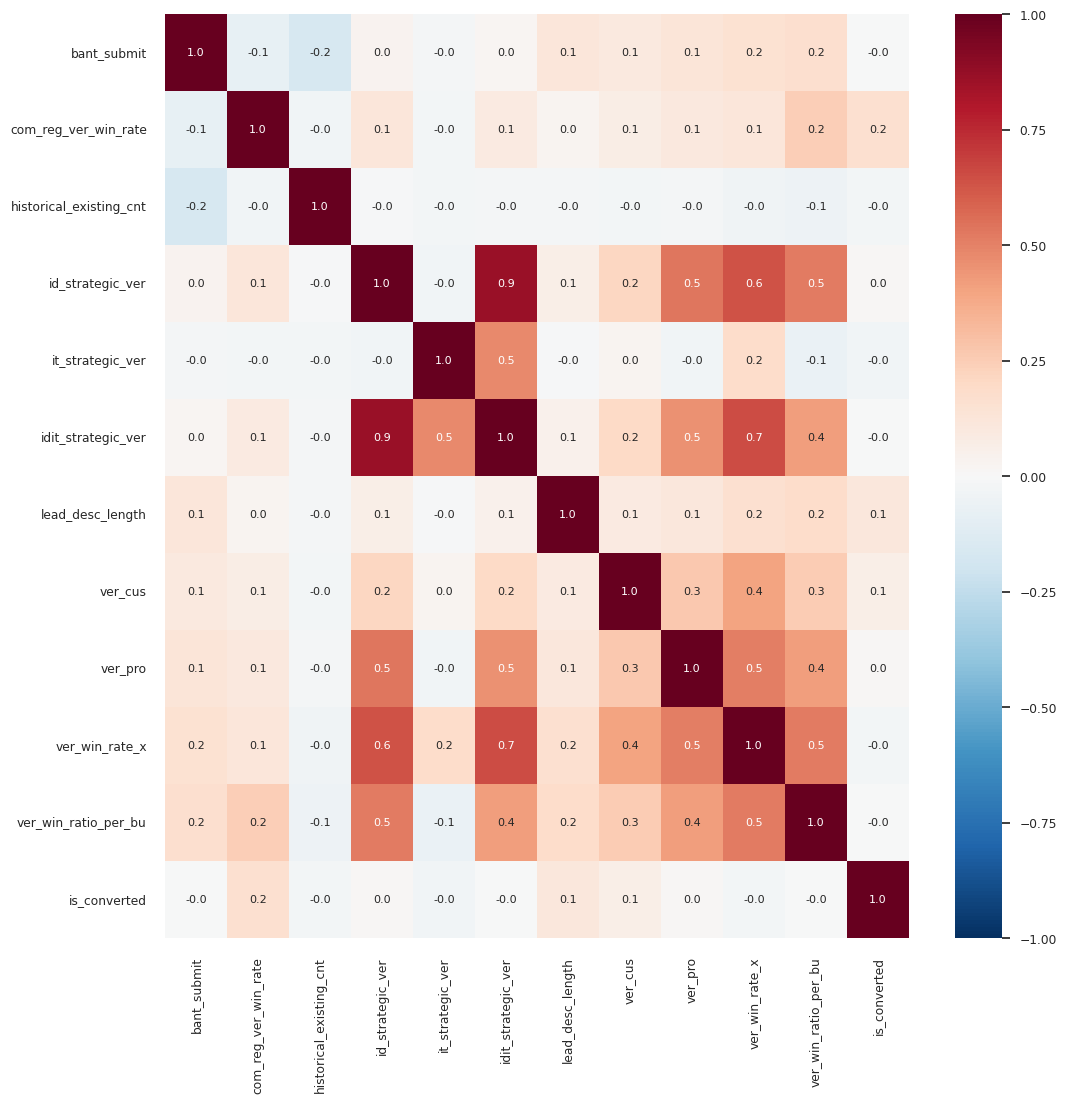

In [ ]:
# correlation

sns.set(font_scale=0.8)
plt.figure(figsize=(12,12))
sns.heatmap(df_train.iloc[:,:].corr(),fmt='.1f',vmax=1, vmin=-1,cmap='RdBu_r',annot=True, annot_kws={'size':8})

In [ ]:
# Visualization

# x distplot
def show_dist_plot_x(columns,data):
    i = 0
    plt.figure(figsize=(24,16))
    plt.subplots(3,5,figsize=(24,16))
    for col in columns:
        i += 1
        plt.subplot(3,5,i)
        sns.histplot(data[col], kde=True)
    plt.tight_layout()

# boxplot
def show_dist_plot_box(columns,data):
    i = 0
    plt.figure(figsize=(24,16))
    plt.subplots(3,5,figsize=(24,16))
    for col in columns:
        i += 1
        plt.subplot(3,5,i)
        sns.boxplot(data[col],color='skyblue')
    plt.tight_layout()

<Figure size 2400x1600 with 0 Axes>

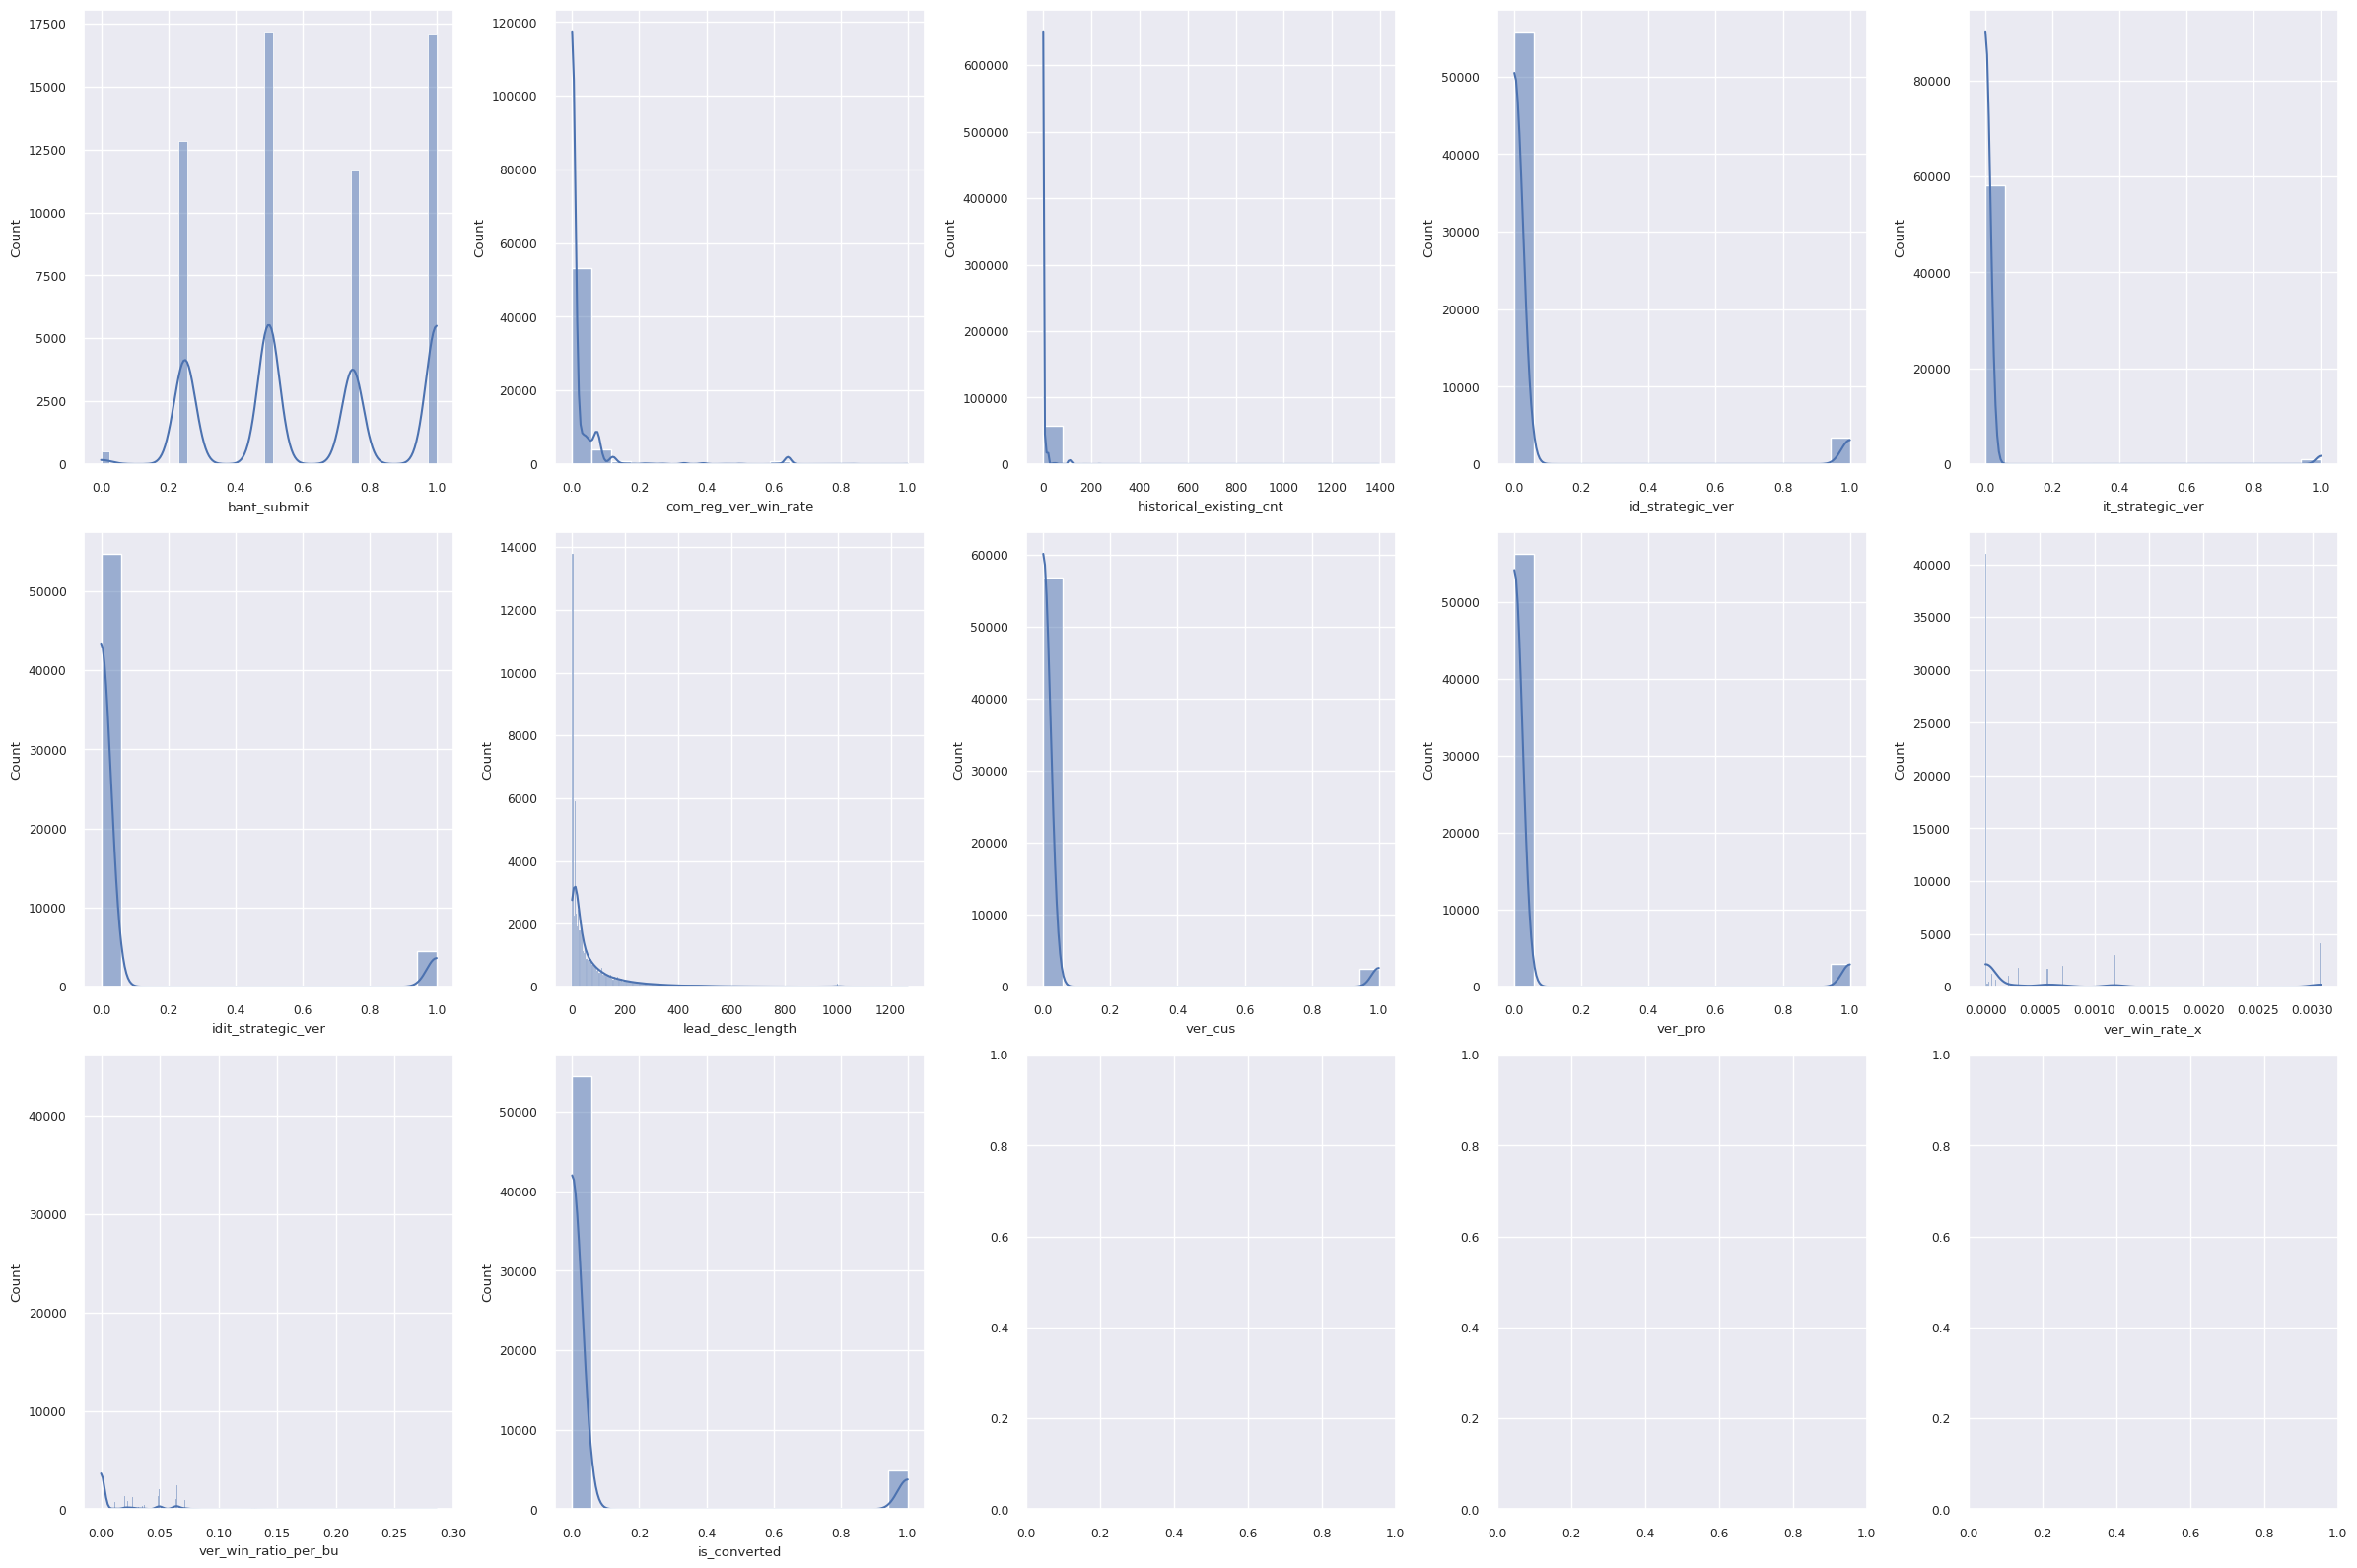

In [ ]:
num_cols = df_train.columns[df_train.dtypes!=object]
show_dist_plot_x(df_train.filter(items=num_cols).columns, df_train)

<Figure size 2400x1600 with 0 Axes>

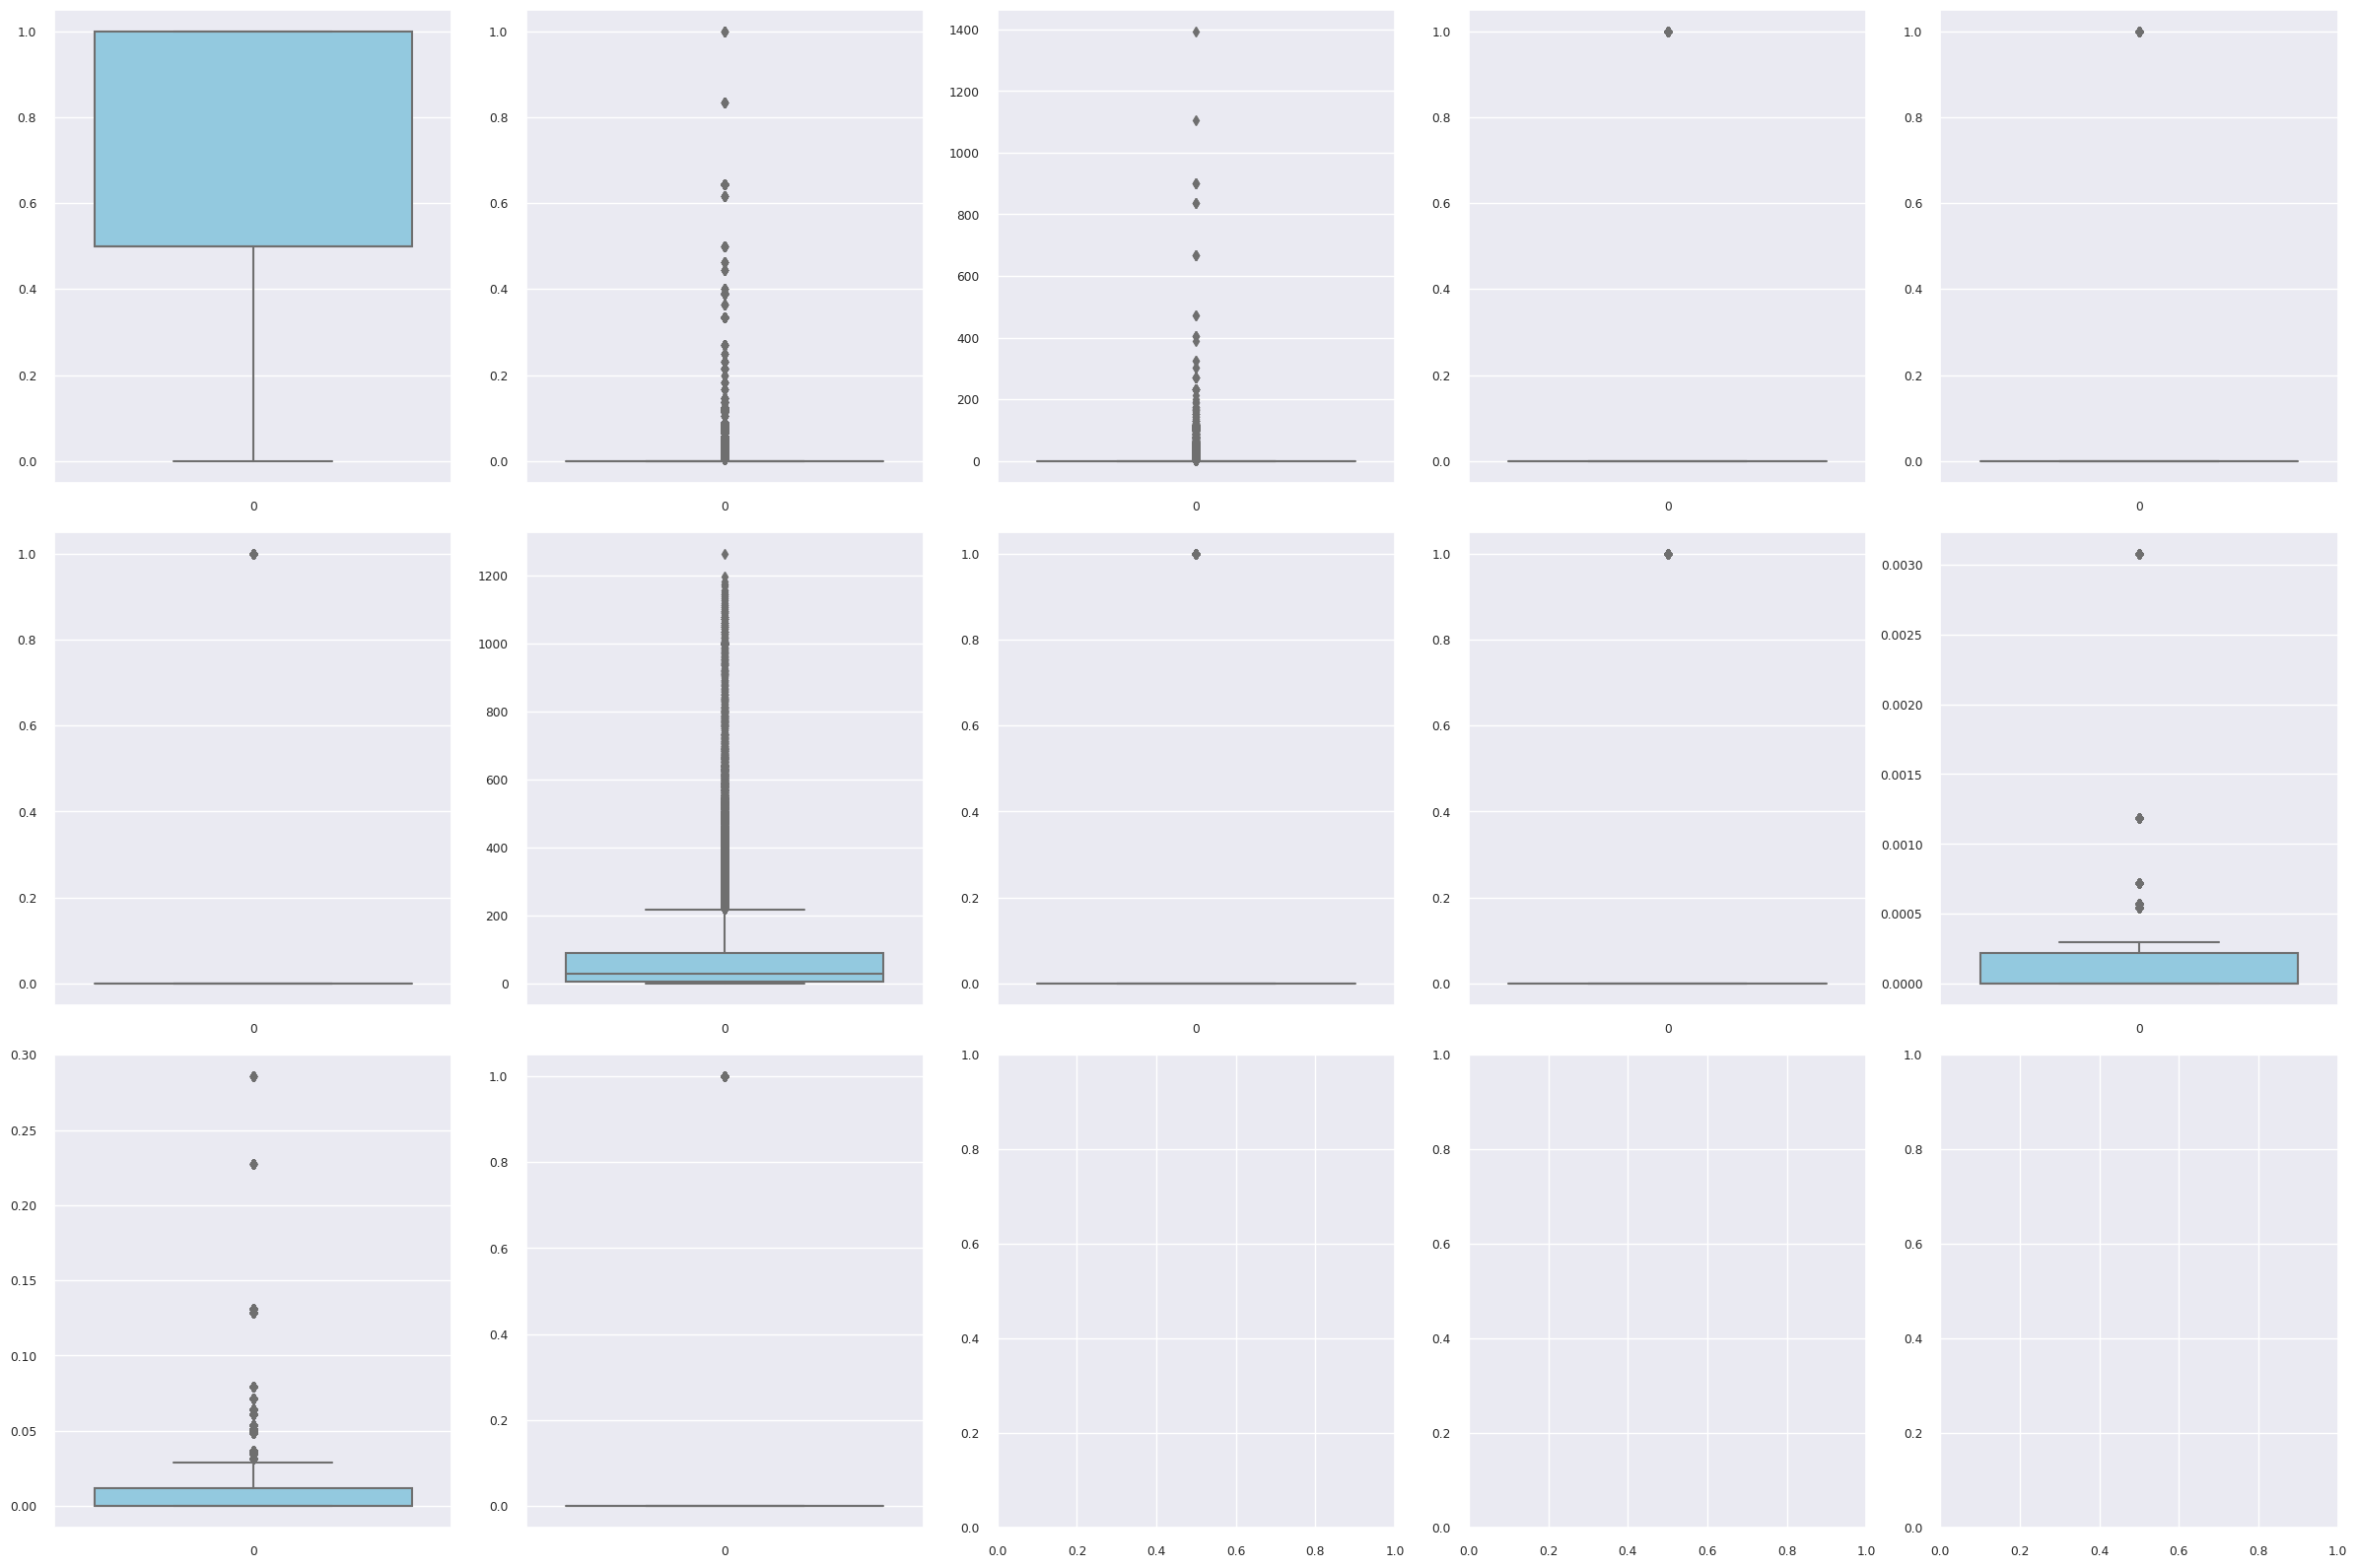

In [ ]:
show_dist_plot_box(df_train.filter(items=num_cols).columns, df_train)

In [ ]:
# cond1 = df_train["총상환이자대비총상환원금비율"] > 0.8 * 1e9
# cond2 = df_train["총상환원금대비총상환이자비율"] > 0.4 * 1e8

# new_train = train[(~cond1) & (~cond2)].reset_index(drop=True)

# train["총상환이자대비총상환원금비율"].describe(percentiles=(0.1, 0.25, 0.5, 0.75, 0.9, 0.99)).astype(int)
# 100 * sum(train["총상환이자대비총상환원금비율"] > 1000) / len(train)
# train.loc[train["총상환이자대비총상환원금비율"] > 1000, "총상환이자대비총상환원금비율"] = 1000 + np.log(train.loc[train["총상환이자대비총상환원금비율"] > 1000, "총상환이자대비총상환원금비율"])

## Feature Engineering

In [ ]:
# feature engineering

cell_start_time = time()

clf = setup(data = df_train,
            target = 'is_converted',

            normalize = True,
            normalize_method = 'minmax', # default = zscore

            train_size = 0.8,
            # transformation = True, # power transform (yeo-johnson)

            fold = 5, # default = 10
            fold_shuffle = True,

            ignore_features = ['customer_idx', 'id_strategic_ver', 'it_strategic_ver'], # exclude
            # numeric_features = ['bant_submit', 'com_reg_ver_win_rate', 'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
            #                     'idit_strategic_ver', 'lead_desc_length', 'ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu'],
            # categorical_features = ['customer_country', 'business_unit', 'customer_type', 'enterprise', 'customer_job',
            #                         'inquiry_type', 'product_category', 'customer_position', 'response_corporate', 'expected_timeline',
            #                         'business_area', 'business_subarea', 'lead_owner'], # onehotencoding (or targetencoding)
            # date_features = [], # date(ymdt) to onehotencoding (or targetencoding)

            session_id = 123, # random state number

            use_gpu = True,

            # feature_selection = True,
            # feature_selection_method = 'classic', # or 'boruta'
            # classic based on permutation importance

            fix_imbalance = True, # fix target imbalance (default method = SMOTE)

            # custom_pipeline = pipe, preprocess =False
            # 두 개는 세트, 사용자가 원하는 파이프라인을 구성할 수 있다.)
            )

cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,123
1,Target,is_converted
2,Target type,Binary
3,Original data shape,"(59299, 26)"
4,Transformed data shape,"(98978, 23)"
5,Transformed train set shape,"(87118, 23)"
6,Transformed test set shape,"(11860, 23)"
7,Ignore features,3
8,Ordinal features,1
9,Numeric features,21


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

## 3. 모델 학습

### 모델 정의

In [ ]:
models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
cell_start_time = time()
top5_models = compare_models(sort = 'F1', n_select = 5)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9405,0.9576,0.6425,0.6346,0.6384,0.6060,0.6061,0.7980
rf,Random Forest Classifier,0.9442,0.9576,0.5827,0.6876,0.6307,0.6008,0.6032,7.8260
et,Extra Trees Classifier,0.9417,0.9491,0.5760,0.6663,0.6178,0.5864,0.5883,5.4680
lightgbm,Light Gradient Boosting Machine,0.9324,0.9494,0.6101,0.5831,0.5960,0.5591,0.5594,1.9680
dt,Decision Tree Classifier,0.9214,0.7857,0.6116,0.5170,0.5602,0.5174,0.5197,1.0400
gbc,Gradient Boosting Classifier,0.9036,0.9025,0.5943,0.4352,0.5022,0.4503,0.4571,16.9220
knn,K Neighbors Classifier,0.8826,0.8593,0.6848,0.3794,0.4882,0.4280,0.4519,7.4360
ada,Ada Boost Classifier,0.8581,0.8383,0.5559,0.3010,0.3904,0.3180,0.3374,4.4320
lr,Logistic Regression,0.7493,0.8019,0.7577,0.2116,0.3308,0.2327,0.3049,1.1780
ridge,Ridge Classifier,0.7402,0.0000,0.7639,0.2063,0.3248,0.2250,0.2994,0.4100


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

CELL RUN TIME :  312.3351833820343


### 모델 학습

### 모델 성능 보기

In [ ]:
top5_models

[XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device='gpu', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=-1,
               num_parallel_tree=None, objective='binary:logistic', ...),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
 

## 4. 제출하기

### 테스트 데이터 예측

### 제출 파일 작성

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**